<a href="https://colab.research.google.com/github/errec-sun/brain/blob/master/Copy__%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%B7%D0%B0%D1%80%D0%BF%D0%BB%D0%B0%D1%82%D1%8B_%D0%BF%D0%BE_%D0%B1%D0%B0%D0%B7%D0%B5_hh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import re
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split

from google.colab import files

Using TensorFlow backend.


#Загружаем базу

In [0]:
# Для загрузки данных используем drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
fixed_df = pd.read_csv('/content/drive/My Drive/hh.csv')# Это то, куда вы скачали файл

#Содержимое базы

In [0]:
# Количество резюме и критерии
print(fixed_df.shape)

(66945, 13)


In [0]:
values = fixed_df.values
print(values.shape)

(66945, 13)


In [0]:
# Пример данных
n = 0 # Берем первое резюме
for i in range(len(values[n])): # Выводим значение каждой графы резюме
  print(i, " ", values[n][i])

0   0
1   Мужчина ,  42 года , родился 6 октября 1976
2   27 000 руб.
3   Старший администратор
4   Липецк , не готов к переезду , не готов к командировкам
5    полная занятость
6    полный день
7   Опыт работы 6 лет 1 месяц

Старший администратор 27 000 руб. Информационные технологии, интернет, телеком Системный администратор Занятость: полная занятость График работы: полный день Опыт работы 6 лет 1 месяц Август 2016 — по настоящее время 2 года 9 месяцев Трц Ривьера Липецк Услуги для бизнеса ... Безопасность, охранная деятельность Старший администратор по сохраности активов Сохраность активов Трц Ривьера. Решение конфликтных ситуаций. Работа с персоналом отдела административного контроля. Май 2015 — Август  2016 1 год 4 месяца НЕТ Липецк Охранник Охрана объекта. Апрель 2013 — Апрель  2015 2 года 1 месяц НЕТ Липецк Охрана Охрана имущества. Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Управление персоналом Урегулирование конфликтов Умени

In [0]:
df = fixed_df.copy()

In [0]:
print(df.columns)

Index(['Unnamed: 0', 'Пол, возраст', 'ЗП', 'Ищет работу на должность:',
       'Город', 'Занятость', 'График',
       'Опыт (двойное нажатие для полной версии)',
       'Последенее/нынешнее место работы', 'Последеняя/нынешняя должность',
       'Образование и ВУЗ', 'Обновление резюме', 'Авто'],
      dtype='object')


In [0]:
df.head(10)

In [0]:
def getParameterSalary(arg):
    global salaryStr, num #т.к. используем, меняем в функции
    
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(arg) != float):
        num = arg
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')
        
        # Получаем чисто валюту, убираем цифры
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','')
        
        # Конвертируем в рубли, если валюта
        if curr == 'USD':
            num = float(num)*65
        elif curr == 'KZT':
            num = float(num)*0.17
        elif curr=='грн':
            num = float(num)*2.6
            
        salaryStr = num
        
    #Строчную запись зп в целое число 
    salaryStr = salaryStr.replace(' ', '')
    salaryStr = salaryStr.replace('\xa0', '')
  
    out = int(salaryStr)

    return out

In [0]:
print(df.loc[0, 'ЗП'])

27 000 руб.


In [0]:
print(getParameterSalary(df.loc[1, 'ЗП']))

60000


In [0]:
df['ЗП'] = df['ЗП'].apply(getParameterSalary)

In [0]:
df.head()

In [0]:
df[df['ЗП'] > 100000].head()

In [0]:
df.loc[df['ЗП'] > 100000,'Ищет работу на должность:'].head(10)

8     Менеджер по работе с корпоративными клиентами
9                      IT-инженер,инженер AV-систем
14             Руководитель проекта/Project manager
15                    HighLoad, SDS Ceph,DevOps,SRE
20                            Руководитель проектов
22                  Старший системный администратор
24        Руководитель службы технической поддержки
29                                         Аналитик
35                              Инженер-программист
37                            Инженер-системотехник
Name: Ищет работу на должность:, dtype: object

In [0]:
df['ЗП'].quantile([0.1, 0.3, 0.5, 0.7, 0.9])

0.1     25000.0
0.3     40000.0
0.5     60000.0
0.7     85000.0
0.9    170000.0
Name: ЗП, dtype: float64

In [0]:
df2 = df.groupby(['ЗП']).count()

In [0]:
df2[220:240]

In [0]:
df3 = df.groupby(['Занятость']).count()
df3.head(50)

In [0]:
def getCity(arg):

  # Все, что до запятой
  index = 0
  while (arg[index] != ","):
    index += 1
    
  # Строка до "," - наш город
  cityStr = arg[:index]

  return cityStr

In [0]:
print(getCity(df.loc[1, 'Город']))

Сочи 


In [0]:
df['Гор'] = df['Город'].apply(getCity)

In [0]:
df.head()

In [0]:
df4 = df.groupby(['Гор']).count()
df4.head(40)

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
Гор,,,,,,,,,,,,,
Aktau,1,1,1,1,1,1,1,1,1,1,1,1,1
Aktobe,1,1,1,1,1,1,1,1,1,1,1,1,1
Almaty,28,28,28,28,28,28,28,28,28,28,28,28,28
Armenia,4,4,4,4,4,4,4,4,4,4,4,4,4
Astana,1,1,1,1,1,1,1,1,1,1,1,1,1
Astrakhan,1,1,1,1,1,1,1,1,1,1,1,1,1
Atyrau,5,5,5,5,5,5,5,5,5,5,5,5,5
Bahrain,1,1,1,1,1,1,1,1,1,1,1,1,1
Baku,1,1,1,1,1,1,1,1,1,1,1,1,1


In [0]:
df[(df['Гор'] == 'Москва ') & (df['ЗП'] > 300000)].head(20)

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто,Гор
196,196,"Мужчина , 41 год , родился 19 января 1978",500000,"Технический Директор, Директор по развитию биз...","Москва , не готов к переезду , готов к команди...",полная занятость,полный день,Опыт работы 16 лет 4 месяца\n\nТехнический Дир...,Kraftway Corporation PLC,Зам. директора департамента развития бизнеса,Высшее образование (Магистр) 2000 Ульяновский ...,27.04.2019 19:16,Не указано,Москва
224,224,"Мужчина , 40 лет , родился 2 сентября 1978",350000,Технический директор / CTO,"Москва , м. Бульвар Дмитрия Донского , не гот...",полная занятость,полный день,Опыт работы 14 лет 1 месяц\n\nТехнический дире...,ООО Национальная платформа,Руководитель отдела разработки,"Высшее образование 2007 МИРЭА ПО АСУ и ВС, Кра...",27.04.2019 18:39,Имеется собственный автомобиль,Москва
302,302,"Мужчина , 44 года , родился 9 ноября 1974",350000,"Руководитель проектов, IT-Руководитель, Руково...","Москва , готов к переезду (Санкт-Петербург) , ...","проектная работа, полная занятость","гибкий график, полный день",Опыт работы 21 год 7 месяцев\n\nРуководитель п...,ГлобалЭлектроСервис,Руководитель программ автоматизации - Начальни...,Высшее образование 2005 Высшая школа корпорати...,27.04.2019 16:31,Имеется собственный автомобиль,Москва
346,346,"Мужчина , 43 года , родился 21 июня 1975",400000,"Руководитель разработки, Системный архитектор","Москва , м. Ховрино , готов к переезду (Нидер...",полная занятость,полный день,Опыт работы 21 год 4 месяца\n\nРуководитель ра...,Умная Цифра,Старший системный архитектор,Высшее образование 1998 Московский физико-тех...,27.04.2019 15:18,Не указано,Москва
626,626,Мужчина,350000,"Руководитель по цифровизации, CIO, CDO, IT-пар...","Москва , готов к переезду (Санкт-Петербург) , ...",полная занятость,полный день,Опыт работы 25 лет 4 месяца\n\nРуководитель по...,"Норильский никель, ГМК",Руководитель направления стратегии ИТ,Высшее образование 1996 Московский государстве...,27.04.2019 09:43,Имеется собственный автомобиль,Москва
628,628,"Мужчина , 39 лет , родился 31 мая 1979",3000000,"Руководитель IT проектов, Роботизация, Автомат...","Москва , м. Щелковская , готов к переезду (Бе...","частичная занятость, проектная работа, полная...","гибкий график, полный день, вахтовый метод, у...",Опыт работы 23 года 4 месяца\n\nРуководитель I...,HAMSTER ROBOTICS,Заместитель директора,Высшее образование 2019 Московский финансово-...,27.04.2019 09:41,Имеется собственный автомобиль,Москва
887,887,"Мужчина , 46 лет , родился 3 января 1973",360000,Руководитель отдела ИТ,"Москва , м. Мякинино , готов к переезду , гот...",полная занятость,полный день,Опыт работы 20 лет 1 месяц\n\nРуководитель отд...,"ООО «МВС ГРУП""",Ведущий руководитель проекта,Высшее образование 1995 Уфимский государствен...,26.04.2019 19:12,Имеется собственный автомобиль,Москва
982,982,"Мужчина , 70 лет , родился 2 апреля 1949",350000,Эксперт (специалист) по информационной безопас...,"Москва , м. Планерная , не готов к переезду ,...",полная занятость,полный день,Опыт работы 51 год 10 месяцев\n\nЭксперт (спец...,"ООО ""КАБЕСТ"", Группа компаний ""Астерос""","Директор департамента, Руководитель службы Гла...",Высшее образование (Кандидат наук) 2006 Projec...,26.04.2019 15:40,Не указано,Москва
1158,1158,"Мужчина , 42 года , родился 23 декабря 1976",350000,IT директор,"Москва , м. Теплый Стан , не готов к переезду...",полная занятость,полный день,Опыт работы 15 лет 11 месяцев\n\nIT директор 3...,Max Group,Руководитель IT департамента,Высшее образование (Кандидат наук) 2007 Волго...,26.04.2019 11:49,Не указано,Москва
1439,1439,"Мужчина , 41 год , родился 12 ноября 1977",400000,IT Директор / Руководитель отдела IT,"Москва , м. Водный стадион , готов к переезду...",полная занятость,полный день,Опыт работы 18 лет\n\nIT Директор / Руководите...,АгроДиджит

In [0]:
df5 = df.groupby(['Гор', 'ЗП']).count()
df5.head(50)

Unnamed: 0  ...  Авто
Гор                       ЗП                   ...      
Aktau                     200000            1  ...     1
Aktobe                    110000            1  ...     1
Almaty                    100               1  ...     1
                          400               1  ...     1
                          800               1  ...     1
                          1000              1  ...     1
                          1500              1  ...     1
                          1700              1  ...     1
                          2000              2  ...     2
                          2500              1  ...     1
                          4000              1  ...     1
                          60000             1  ...     1
                          200000            2  ...     2
                          250000            1  ...     1
                          300000            3  ...     3
                          350000            1  ...     1
                          400000            3  ...     3
                          500000            1  ...     1
                          600000            1  ...     1
                          700000            2  ...     2
                          1300000           1  ...     1
                          2000000           2  ...     2
Armenia                   2500              1  ...     1
                          3000              2  ...     2
                          140000            1  ...     1
Astana                    1000              1  ...     1
Astrakhan                 80000             1  ...     1
Atyrau                    2000              1  ...     1
                          2200              1  ...     1
                          300000            2  ...     2
                          325000            1  ...     1
Bahrain                   400000            1  ...     1
Baku                      650               1  ...     1
Barnaul                   50000             2  ...     2
Belgorod                  170000            2  ...     2
Bishkek                   350               1  ...     1
                          2000              2  ...     2
                          140000            1  ...     1
Brazil                    80000             1  ...     1
Bryansk                   200000            2  ...     2
Cheboksary                54321             2  ...     2
Chelyabinsk               720               1  ...     1
                          1500              2  ...     2
                          3000              2  ...     2
                          60000             1  ...     1
                          120000            2  ...     2
China                     1530              1  ...     1
Chita                     20000             1  ...     1
Cyprus                    4200              1  ...     1
Dnieper (Dnepropetrovsk)  10000             1  ...     1

[50 rows x 12 columns]

#Парсим базу

In [0]:
##############################################
####Убрать кодировку в описаниях \xa0 \n
##############################################
fixed_df = fixed_df.drop(fixed_df.columns[0],axis = 1) # Убираем первый столбец с продублированными индексами. Он нам не нужен

i=0
for j in range(12):  # Для каждого из столбцов таблицы
    for i in range(fixed_df.shape[0]): # По всем резюме
        if type(fixed_df.values[i][j])!=float: # если данные текстовые, то заменяем фрагменты кодировки ASCII на отсутствие символов
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\xa0","")
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\n"," ")


In [0]:
# Данные о поле
def getParameterSex(arg):
  out = 0
  
  #Если М, то 1. По умолчанию 0 - Ж
  if(arg[0] == "М"):
    out = 1
  return out

# Данные о возрасте
def getParameterAge(arg):
  out = 0
  
  #Год рождения - 2019
  if (len(arg) > 7):
    ageStr = arg[len(arg)-4:len(arg)] # вычитаем  день и месяц рождения, оставляем последние 4 цифры - год
    out = 2019 - int(ageStr) # от текущего (2019) вычитаем год рождения
  
  return out

# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  out = getParameterAge(arg)
  outClass = 0
  if (out > 18): # больше, чем 18 лет
    outClass = 1
  if (out > 23): # больше, чем 23 лет
    outClass = 2
  if (out > 28): # больше, чем 28 лет
    outClass = 3
  if (out > 33): # больше, чем 33 лет
    outClass = 4
  if (out > 38): # больше, чем 38 лет
    outClass = 5
  if (out > 43): # больше, чем 43 лет
    outClass = 6
  if (out > 48): # больше, чем 48 лет
    outClass = 7
  if (out > 53): # больше, чем 53 лет
    outClass = 8
  if (out > 58): # больше, чем 58 лет
    outClass = 9 
  if (out > 63): # больше, чем 63 лет
    outClass = 10
    
  # На выходе получаем вектор с нужной категорией возраста
  return list(utils.to_categorical(outClass, 11).astype('int'))

# Зарплата
def getParameterSalary(arg):
    global salaryStr, num #т.к. используем, меняем в функции
    
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(arg) != float):
        num = arg
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')
        
        # Получаем чисто валюту, убираем цифры
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','')
        
        # Конвертируем в рубли, если валюта
        if curr == 'USD':
            num = float(num)*65
        elif curr == 'KZT':
            num = float(num)*0.17
        elif curr=='грн':
            num = float(num)*2.6
            
        salaryStr = num
        
    #Строчную запись зп в целое число    
    out = int(salaryStr)

    return out

# Данные о городе
def getParameterCity(arg):
  out = [0, 0, 0, 1] #если никаких данных нет

  # Все, что до запятой
  index = 0
  while (arg[index] != ","):
    index += 1
    
  # Строка до "," - наш город
  cityStr = arg[:index]
  
  # Список городов миллиоников, если не Москва или Санкт-Петербург
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  
  # кодируем вектор города
  if (cityStr == "Москва"):
    out[0] = 1
    out[3] = 0
  if (cityStr == "Санкт-Петербург"):
    out[1] = 1
    out[3] = 0
  if (cityStr in millionCities):
    out[2] = 1
    out[3] = 0
  
  return out

# Данные о желаемой занятости
def getParameterEmployment(arg):
  out = [0, 0, 0, 0]
  
  if ("стажировка" in arg):
    out[0] = 1
  if ("частичная занятость" in arg):
    out[1] = 1
  if ("проектная работа" in arg):
    out[2] = 1
  if ("полная занятость" in arg):
    out[3] = 1
  
  return out

# Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0]
  
  if ("гибкий график" in arg):
    out[0] = 1
  if ("полный день" in arg):
    out[1] = 1
  if ("сменный график" in arg):
    out[2] = 1
  if ("удаленная работа" in arg):
    out[3] = 1
  
  return out

# Данные об образовании
def getParameterEducation(arg):
  out = [0, 0, 0, 0,0] #По умолчанию не указано
  
  if ("Высшее" in arg):
    out[0] = 1
  if ("Higher education" in arg):
    out[0] = 1
  if ("Среднее специальное" in arg):
    out[1] = 1
  if ("Неоконченное высшее" in arg):
    out[2] = 1
  if ("Среднее образование" in arg):
    out[3] = 1
  
  return out

# Данные об опыте работы
def getParameterExperience(arg):
  out = 0
  
  #Проверяем, если не пустая строка
  symbols = 0
  for s in arg:
    if (s != " "):
      symbols += 1
  
  #Находим индексы пробелов около фразы "опыт работы"
  if (symbols > 10):
    spacesIndexes = []
    index = 0
    while ((len(spacesIndexes) < 5) & (index < len(arg))):
      if (arg[index] == " "):
        spacesIndexes.append(index)
      index += 1

    years = 0
    months = 0

    #print(arg)
    # Проверяем, если первый символ после второго пробела - м(месяц)
    if (arg[spacesIndexes[2]+1] != "м"):
      if (len(spacesIndexes) >= 3):
        yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]] # Записываем в строку значение лет
        years = int(yearsStr)
        #print("Лет - ", yearsStr)
      #else:
        #print("Нет годов")
      
      
      if (len(spacesIndexes) >= 5):
        monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]] # Записываем в строку значение месяцев
        #print("Месяцев - ", monthsStr)
        if(arg[spacesIndexes[2]+1] == "м"):
          months = int(monthsStr)
      #else:
        #print("Нет месяцев")
        
    else:
      if (len(spacesIndexes) >= 3):
        monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
        months = int(monthsStr)
        #print("Месяцев - ", monthsStr)
      #else:
        #print("Нет годов")

    out = 12*years + months
  
  return out

# Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = getParameterExperience(arg)
  outClass = 0
  if (out > 6): # если больше 6 месяцев
    outClass = 1
  if (out > 12): # если больше 12 месяцев
    outClass = 2
  if (out > 24): # если больше 24 месяцев
    outClass = 3
  if (out > 36): # если больше 36 месяцев
    outClass = 4
  if (out > 60): # если больше 60 месяцев
    outClass = 5
  if (out > 96): # если больше 96 месяцев
    outClass = 6
  if (out > 120): # если больше 120 месяцев
    outClass = 7
  if (out > 156): # если больше 156 месяцев
    outClass = 8
  if (out > 192): # если больше 192 месяцев
    outClass = 9 
  if (out > 240): # если больше 240 месяцев
    outClass = 10
  
  return list(utils.to_categorical(outClass, 11).astype('int'))

# Извлекаем все параметры
def getAllParameters(val):
  sex = getParameterSex(val[0]) #параметры о поле
  age = getParameterAgeVect(val[0]) #параметры о возрасте
  city = getParameterCity(val[3]) #параметры о городе
  employment = getParameterEmployment(val[4]) #параметры о желаемой занятости
  shedule = getParameterSchedule(val[5]) #параметры о желаемом графике
  education = getParameterEducation(val[9]) #параметры об образовании
  experience = getParameterExperienceVector(val[6]) #параметры об опыте
  out = [] 
  
# Склеиваем все параметры в вектор  
  out.append(sex)
  out += age
  out += city
  out += employment
  out += shedule
  out += education
  out += experience
  
  return out

# Создаем тренировочную выборку
def get01Data(values):
  xTrain = []
  yTrain = []
  
  # Предсказывать будем зарплату
  for val in values:
    y = getParameterSalary(val[1])
    
    # Все, что не зарплата - обучающая выборка
    if (y != -1):
      x = getAllParameters(val)
      xTrain.append(x)
      yTrain.append(y/1000)
  
  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)
  
  #minY = yTrain.min()
  #maxY = yTrain.max()
  #yTrain = (yTrain - minY)/(maxY-minY)
  
  return (xTrain, yTrain)

#Нейронка по простым данным

In [0]:
(xTrain01, yTrain) = get01Data(fixed_df.values) # Извлекаем значения загруженного набора данных

In [0]:
# Размер набора параметров и зарплат
print(xTrain01.shape) 
print(yTrain.shape)

(66945, 40)
(66945,)


In [0]:
n = 5 # Пример обработанных данных
print(xTrain01[n])
print(yTrain[n])

[1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0]
50.0


Train on 46861 samples, validate on 20084 samples
Epoch 1/50
 - 3s - loss: 21320.2312 - mean_absolute_error: 78.0118 - val_loss: 6903.8981 - val_mean_absolute_error: 47.1143
Epoch 2/50
 - 2s - loss: 16025.8854 - mean_absolute_error: 51.5394 - val_loss: 5249.0679 - val_mean_absolute_error: 41.2451
Epoch 3/50
 - 2s - loss: 14802.2204 - mean_absolute_error: 49.6048 - val_loss: 5260.1008 - val_mean_absolute_error: 41.9488
Epoch 4/50
 - 2s - loss: 14720.9498 - mean_absolute_error: 49.1555 - val_loss: 5183.4753 - val_mean_absolute_error: 41.1651
Epoch 5/50
 - 2s - loss: 14647.8747 - mean_absolute_error: 48.8117 - val_loss: 5173.2298 - val_mean_absolute_error: 41.2000
Epoch 6/50
 - 2s - loss: 14605.1425 - mean_absolute_error: 48.5133 - val_loss: 5097.3731 - val_mean_absolute_error: 40.7262
Epoch 7/50
 - 2s - loss: 14562.0559 - mean_absolute_error: 48.2860 - val_loss: 5091.3065 - val_mean_absolute_error: 40.7698
Epoch 8/50
 - 2s - loss: 14537.3916 - mean_absolute_error: 48.0604 - val_loss: 509

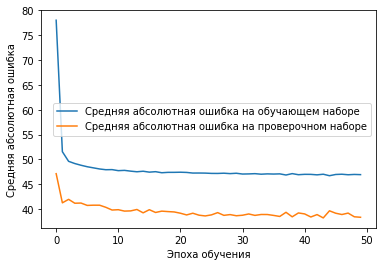

In [0]:
# Обучаем модель полученными данными
model = Sequential()
model.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
model.add(Dense(100, activation='relu'))
#model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])

history = model.fit(xTrain01, 
                    yTrain, 
                    epochs=50, 
                    validation_split=0.3, 
                    verbose=2)

plt.plot(history.history['mean_absolute_error'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mean_absolute_error'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [0]:
# В качестве нормализации данных используем готовую библиотеку 
from sklearn.preprocessing import StandardScaler
yScaler = StandardScaler()

# Скармливаем объекту двумерный вектор
yScaler.fit(yTrain.reshape(-1, 1))

# Нормализуем по нормальному распределению
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))

print(yTrainScaled.shape)
print(yTrain[1])
print(yTrainScaled[1])

(66945, 1)
60.0
[-0.18548226]


Train on 43514 samples, validate on 23431 samples
Epoch 1/50
 - 7s - loss: 1.3959 - mean_absolute_error: 0.5166 - val_loss: 0.4356 - val_mean_absolute_error: 0.4308
Epoch 2/50
 - 7s - loss: 1.3348 - mean_absolute_error: 0.5021 - val_loss: 0.4285 - val_mean_absolute_error: 0.4314
Epoch 3/50
 - 7s - loss: 1.3124 - mean_absolute_error: 0.4931 - val_loss: 0.4196 - val_mean_absolute_error: 0.4229
Epoch 4/50
 - 7s - loss: 1.2990 - mean_absolute_error: 0.4866 - val_loss: 0.4172 - val_mean_absolute_error: 0.4205
Epoch 5/50
 - 7s - loss: 1.2950 - mean_absolute_error: 0.4832 - val_loss: 0.4146 - val_mean_absolute_error: 0.4177
Epoch 6/50
 - 7s - loss: 1.2896 - mean_absolute_error: 0.4817 - val_loss: 0.4125 - val_mean_absolute_error: 0.4152
Epoch 7/50
 - 7s - loss: 1.2834 - mean_absolute_error: 0.4777 - val_loss: 0.4102 - val_mean_absolute_error: 0.4123
Epoch 8/50
 - 7s - loss: 1.2833 - mean_absolute_error: 0.4760 - val_loss: 0.4063 - val_mean_absolute_error: 0.4076
Epoch 9/50
 - 7s - loss: 1.275

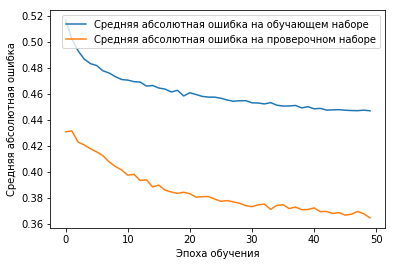

In [0]:
# Обучаем модель стандартизированными данными
modelS = Sequential()
modelS.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
modelS.add(Dense(128, activation='relu'))
modelS.add(Dense(1000, activation='tanh'))
modelS.add(Dropout(0.5))
modelS.add(Dense(100, activation='relu'))
modelS.add(Dense(1, activation='linear'))

modelS.compile(optimizer=Adam(lr=1e-6), loss='mse', metrics=['mae'])

history = modelS.fit(xTrain01, 
                    yTrainScaled, 
                    epochs=50, 
                    validation_split=0.35, 
                    verbose=2)

plt.plot(history.history['mean_absolute_error'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mean_absolute_error'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [0]:
# Делаем предсказание и приводим его к начальному виду
pred = modelS.predict(xTrain01)
predUnscaled = yScaler.inverse_transform(pred).flatten()

# Среднее значение ошибки 
delta = predUnscaled - yTrain
absDelta = abs(delta)
print(sum(absDelta) / len(absDelta))

45.84152036192581


#Оценка результатов

In [0]:
yy = model.predict(xTrain01) # Результат для всего тренировочного набора

In [0]:
n = 10
for i in range(n):
  print(yTrain[i], " ", yy[i][0], " ", abs(yTrain[i]-yy[i][0]))

27.0   84.40328   57.403282165527344
60.0   123.41849   63.418487548828125
65.0   126.8806   61.88059997558594
70.0   101.20865   31.208648681640625
45.0   96.81119   51.811187744140625
50.0   76.3661   26.36609649658203
100.0   60.609573   39.39042663574219
80.0   127.41628   47.416282653808594
120.0   121.58312   1.5831222534179688
120.0   99.16507   20.834930419921875


#Используем простые текстовые данные

In [0]:
###########################
# Очистка текста и превращение в набор слов
##########################
def text2Words(text):
  # Убираем нетекстовые символы
  text = text.replace(".", "")
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower()
  
  words = []
  currWord = ""
  for symbol in text:
    # если не кодировка и не пробел, то добавляем символ, пока не конец слова
    if (symbol != "\ufeff"):
      if (symbol != " "):
        currWord += symbol
      else:
        if (currWord != ""):
          words.append(currWord)
          currWord = ""

  if (currWord != ""):
        words.append(currWord)
  
  return words


###########################
# Создание словаря - все слова, упорядоченные по частоте появления
##########################
def createVocabulary(allWords):
  
  wCount = dict.fromkeys(allWords, 0)

  for word in allWords:
    wCount[word] += 1

  wordsList = list(wCount.items())
  wordsList.sort(key = lambda i:i[1], reverse=1)

  sortedWords = []

  for word in wordsList:
    sortedWords.append(word[0])

  wordIndexes = dict.fromkeys(allWords, 0)
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1

  return wordIndexes


###########################
# Преобразования листа слов в лист индексов
##########################
def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  for word in words:
    
    wordIndex = 0
    wordInVocabulary = word in vocabulary
    
    if (wordInVocabulary):
      index = vocabulary[word]
      if (index < maxWordsCount):
        wordIndex = index
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag
##########################
def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)
  
  for x in trainVector:
    out[x] = 1
    
  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag
##########################
def changeSetTo01(trainSet, wordsCount):
  out = []
  
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount))
    
  return np.array(out)


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag с множественным вхождением
##########################
def changeXTo01Multi(trainVector, wordsCount):
  out = np.zeros(wordsCount)
  
  for x in trainVector:
    out[x] += 1
    
  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag с множественным вхождением
##########################
def changeSetTo01Multi(trainSet, wordsCount):
  out = []
  
  for x in trainSet:
    out.append(changeXTo01Multi(x, wordsCount))
    
  return np.array(out)

# Выкачиваем данные по профессиям
def getXTrainTProf(values):
  xTrainTProf = []
  allTextProf = ""
  
  for val in values:
    currText = ""
    if (type(val[3]) != float):
      currText += val[2]
    if (type(val[7]) != float):
      currText += " " + val[7]
    
    allTextProf += currText + " "
    if (getParameterSalary(val[1]) != -1): # Проверяем, если есть данные о зарплате
      xTrainTProf.append(currText)
  
  xTrainTProf = np.array(xTrainTProf)
  
  return (xTrainTProf, allTextProf)

# Выкачиваем данные по резюме
def getXTrainTRez(values):
  xTrainTRez = []
  allTextRez = ""
  
  for val in values:
    currText = ""
    if (type(val[7]) != float):
      currText += val[6]
    
    allTextRez += currText + " "
    if (getParameterSalary(val[1]) != -1):
      xTrainTRez.append(currText)
  
  xTrainTRez = np.array(xTrainTRez)
  
  return (xTrainTRez, allTextRez)

# Делаем векторное представление слов
def changeSetToIndexes(xTrainProf, vocabulary, maxWordsCount):
  xTrainProfIndexes = []
  
  for text in xTrainProf:
    currWords = text2Words(text)
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount)
    xTrainProfIndexes.append(currIndexes)
  
  xTrainProfIndexes = np.array(xTrainProfIndexes)
  
  return xTrainProfIndexes

#Загружаем простые текстовые данные

In [0]:
# Вытаскиваем професии для выборки
(xTrainTProf, allTextProf) = getXTrainTProf(fixed_df.values) 

In [0]:
print(len(allTextProf)) # длина всего словаря профессий
print(allTextProf[:20]) # пример текста всех профессий (первые 20 символов)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
print(xTrainTProf[10]) # пример профессии 11го резюме

Системный администратор ГБУСОН "Кавказ"


#Формируем словарь

In [0]:
words = text2Words(allTextProf) # разбиваем текст профессий на слова
vocabulary = createVocabulary(words) # создаем словарь частотности

In [0]:
print(len(vocabulary)) # длина такого словаря

45833


#Создаём обучающие выборки

In [0]:
# Превращаем слова в индексы, используем самые частые 10000 слов
xTrainProfIndexes = changeSetToIndexes(xTrainTProf, vocabulary, 10000) 
xTrainProf01 = changeSetTo01(xTrainProfIndexes, 10000) # Формат 0 1

In [0]:
n = 0
print(xTrainTProf[n]) # профессия
print(xTrainProfIndexes[n]) # профессия через индексы

Старший администратор Трц Ривьера
[81, 3, 1418, 2242]


In [0]:
print(xTrainProf01.shape) # посмотрим размер выборки

(66945, 10000)


#Обучаем нейронку на простых текстовых данных

Train on 46861 samples, validate on 20084 samples
Epoch 1/50
 - 27s - loss: 20602.7450 - mean_absolute_error: 72.8083 - val_loss: 5842.9803 - val_mean_absolute_error: 36.6168
Epoch 2/50
 - 27s - loss: 15799.0676 - mean_absolute_error: 51.6566 - val_loss: 5375.2679 - val_mean_absolute_error: 45.2161
Epoch 3/50
 - 26s - loss: 15349.1867 - mean_absolute_error: 54.6709 - val_loss: 5361.1742 - val_mean_absolute_error: 45.2865
Epoch 4/50
 - 27s - loss: 15324.9011 - mean_absolute_error: 54.4210 - val_loss: 5372.6192 - val_mean_absolute_error: 45.7605
Epoch 5/50
 - 29s - loss: 15298.4933 - mean_absolute_error: 54.4702 - val_loss: 5310.7103 - val_mean_absolute_error: 45.0559
Epoch 6/50
 - 27s - loss: 15273.7348 - mean_absolute_error: 54.1852 - val_loss: 5302.1998 - val_mean_absolute_error: 45.1928
Epoch 7/50
 - 26s - loss: 15248.5307 - mean_absolute_error: 54.1696 - val_loss: 5238.8697 - val_mean_absolute_error: 44.4111
Epoch 8/50
 - 26s - loss: 15224.8644 - mean_absolute_error: 53.8702 - val_l

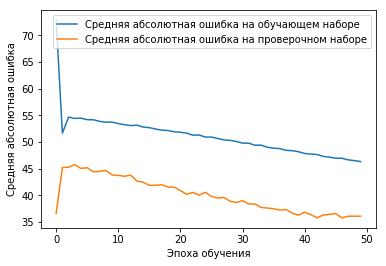

In [0]:
# Предсказываем по предыдущей работе и желаемой
modelTProf = Sequential()
modelTProf.add(BatchNormalization(input_shape=(xTrainProf01.shape[1],)))
modelTProf.add(Dense(100, activation='relu'))
modelTProf.add(Dense(1000, activation='tanh'))
modelTProf.add(Dropout(0.5))
modelTProf.add(Dense(100, activation='relu'))
modelTProf.add(Dense(1, activation='linear'))

modelTProf.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])

history = modelTProf.fit(xTrainProf01, 
                    yTrain, 
                    epochs=50, 
                    validation_split=0.3, 
                    verbose=2)

plt.plot(history.history['mean_absolute_error'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mean_absolute_error'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

#Загружаем сложные текстовые данные

In [0]:
# Вытаскиваем резюме для выборки
(xTrainTRez, allTextRez) = getXTrainTRez(fixed_df.values)

# Преобразуем в слова тексты резюме
words = text2Words(allTextRez)
print(len(words))

39095716


In [0]:
vocabularyRez = createVocabulary(words[:7000000]) # Словарь из 7000000 слов

In [0]:
print(len(vocabularyRez))

197056


In [0]:
maxWordsCount = 1000 # 1000 самых популярных слов, чтобы избежать переобучения
xTrainRezIndexes = changeSetToIndexes(xTrainTRez, vocabularyRez, maxWordsCount) # Превращаем слова в индексы, используем самые частые 
xTrainRez01 = changeSetTo01(xTrainRezIndexes, maxWordsCount) # Формат 0 1

In [0]:
print(len(vocabularyRez)) # Длина словаря 
print(xTrainRez01.shape) # Размер выборки самых частых слов
print(xTrainRez01[555]) # Пример из отформатированной выборки

197056
(66945, 1000)
[1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

#Обучаем нейронку на сложных текстовых данных








Train on 46861 samples, validate on 20084 samples
Epoch 1/200





 - 50s - loss: 20520.8281 - mean_absolute_error: 72.1766 - val_loss: 7227.2451 - val_mean_absolute_error: 46.6521
Epoch 2/200
 - 46s - loss: 18512.5176 - mean_absolute_error: 59.4194 - val_loss: 6238.1957 - val_mean_absolute_error: 38.7002
Epoch 3/200
 - 47s - loss: 17303.6457 - mean_absolute_error: 53.0915 - val_loss: 5622.7522 - val_mean_absolute_error: 35.8682
Epoch 4/200
 - 49s - loss: 16466.6801 - mean_absolute_error: 50.5038 - val_loss: 5303.1566 - val_mean_absolute_error: 36.5609
Epoch 5/200
 - 45s - loss: 15926.9639 - mean_absolute_error: 50.2989 - val_loss: 5201.4033 - val_mean_absolute_error: 38.8795
Epoch 6/200
 - 41s - loss: 15632.2555 - mean_absolute_error: 51.2254 - val_loss: 5234.0223 - val_mean_absolute_error: 41.3977
Epoch 7/200
 - 29s - loss: 15495.1795 - mean_absolute_error: 52.4908 - val_loss: 5310.1674 - val_mean_absolute_error: 43.3680
Epoch 8/200
 - 16s - loss: 15441.1896 - mean_absolute_er

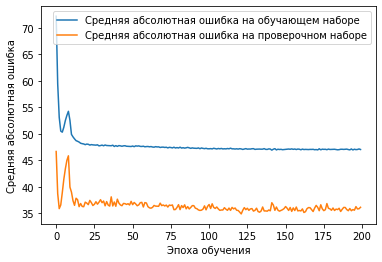

In [0]:
# здесь в параметрах maxWordCount = 1000
modelTRez = Sequential()
modelTRez.add(BatchNormalization(input_shape=(xTrainRez01.shape[1],)))
modelTRez.add(Dense(10, activation='relu'))
modelTRez.add(Dense(100, activation='tanh'))
modelTRez.add(Dense(1, activation='linear'))

modelTRez.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])

history = modelTRez.fit(xTrainRez01, 
                    yTrain, 
                    epochs=200, 
                    validation_split=0.3, 
                    verbose=2)

plt.plot(history.history['mean_absolute_error'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mean_absolute_error'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

#Составная нейронка на всех типах данных одновременно

Train on 50000 samples, validate on 16945 samples
Epoch 1/150
 - 18s - loss: 12945.3280 - mean_absolute_error: 41.0321 - val_loss: 3888.2220 - val_mean_absolute_error: 25.7511
Epoch 2/150
 - 16s - loss: 11925.0369 - mean_absolute_error: 37.1109 - val_loss: 3696.4857 - val_mean_absolute_error: 23.8664
Epoch 3/150
 - 16s - loss: 10943.0541 - mean_absolute_error: 36.2065 - val_loss: 3539.2718 - val_mean_absolute_error: 23.1255
Epoch 4/150
 - 20s - loss: 9400.1110 - mean_absolute_error: 34.4272 - val_loss: 3569.5727 - val_mean_absolute_error: 25.5916
Epoch 5/150
 - 16s - loss: 7615.2534 - mean_absolute_error: 33.1024 - val_loss: 3560.0848 - val_mean_absolute_error: 22.3929
Epoch 6/150
 - 15s - loss: 6390.0112 - mean_absolute_error: 31.9155 - val_loss: 3333.4712 - val_mean_absolute_error: 21.2810
Epoch 7/150
 - 15s - loss: 5412.4046 - mean_absolute_error: 30.6374 - val_loss: 3314.6371 - val_mean_absolute_error: 21.2934
Epoch 8/150
 - 16s - loss: 4938.7489 - mean_absolute_error: 29.7589 - va

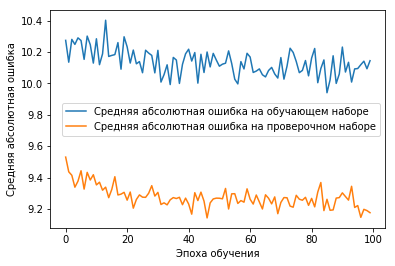

In [0]:
maxWordsCount = 1000 # Устанавливаем самые частые и превращаем их в индексы, выборку
xTrainRezIndexes = changeSetToIndexes(xTrainTRez, vocabularyRez, maxWordsCount)
xTrainRez01 = changeSetTo01(xTrainRezIndexes, maxWordsCount)

input1 = Input((xTrain01.shape[1],))
input2 = Input((xTrainProf01.shape[1],))
input3 = Input((xTrainRez01.shape[1],))

x1 = BatchNormalization()(input1) # Создаем ветку х1
x1 = Dropout(0.5)(x1)
x1 = Dense(10, activation="relu")(x1)
x1 = Dense(1000, activation="relu")(x1)
x1 = Dense(100, activation = "relu")(x1)

#x2 = BatchNormalization()(input2) # Создаем ветку х2
x2 = Dense(25, activation="relu")(input2)
x2 = Dense(8, activation="tanh")(x2)
x2 = Dense(5, activation = "elu")(x2)


#x3 = BatchNormalization()(input3) # Создаем ветку х3
x3 = Dense(1000, activation="tanh")(input3)
x3 = Dense(20, activation = "elu")(x3)
x3 = Dense(5, activation = "elu")(x3)

x = concatenate([x1, x2, x3]) # Объединяем все три ветки

x = Dense(15, activation='linear')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='relu')(x) # Финальный нейрон, делает регрессию

model = Model((input1, input2, input3), x) # В Model загружаем стартовые и последнюю точки 

model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])

history = model.fit([xTrain01[:50000], xTrainProf01[:50000], xTrainRez01[:50000]], 
                    yTrain[:50000], 
                    epochs= 150, 
                    validation_data=([xTrain01[50000:], xTrainProf01[50000:], xTrainRez01[50000:]], 
                    yTrain[50000:]), 
                    verbose=2)

model.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])

history = model.fit([xTrain01[:50000], xTrainProf01[:50000], xTrainRez01[:50000]], 
                    yTrain[:50000], 
                    epochs=100, 
                    validation_data=([xTrain01[50000:], xTrainProf01[50000:], xTrainRez01[50000:]], 
                    yTrain[50000:]), 
                    verbose=2)

model.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])

history = model.fit([xTrain01[:50000], xTrainProf01[:50000], xTrainRez01[:50000]], 
                    yTrain[:50000], 
                    epochs=100, 
                    validation_data=([xTrain01[50000:], xTrainProf01[50000:], xTrainRez01[50000:]], 
                    yTrain[50000:]), 
                    verbose=2)

plt.plot(history.history['mean_absolute_error'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mean_absolute_error'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

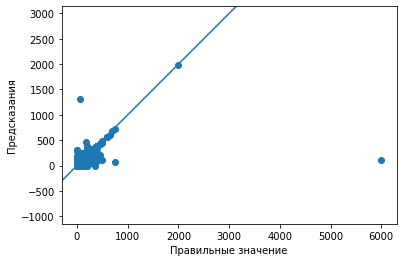

In [0]:
yy = yTrain[50000:] # Зарплата
pred = model.predict([xTrain01[50000:], xTrainProf01[50000:], xTrainRez01[50000:]]) # Предсказанная зарплата
plt.scatter(yy, pred)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-1000, 5000], [-1000, 5000])
plt.show()

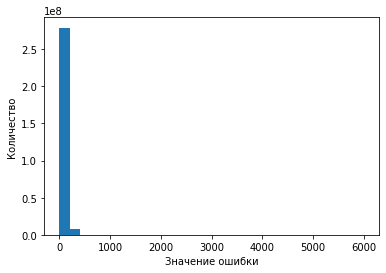

In [0]:
# Гистограмма ошибок
delta = pred - yy # Вычитаем от предсказания правильную зп
plt.hist(abs(delta).flatten(), bins = 30)
plt.xlabel("Значение ошибки")
plt.ylabel("Количество")
plt.show()